<a href="https://colab.research.google.com/github/SidU/LLMs-from-scratch/blob/main/Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continuous Bag of Words (CBOW) Example Using PyTorch

This notebook demonstrates how CBOW works using PyTorch. It includes:
1. Vocabulary and embedding matrix setup.
2. Retrieving embeddings for context words.
3. Averaging context embeddings.
4. Predicting the target word and updating embeddings.

### Import libraries


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

## Vocabulary and Embedding Matrix
We'll start by defining a small vocabulary of 4 words "cat", "dog", "mouse", and "cheese" and an embedding size of 3.
An embedding layer will store random embeddings for each word initially.

In [22]:
# Define vocabulary and embedding dimensions
vocab = ["cat", "dog", "mouse", "cheese"]
vocab_size = len(vocab)  # Vocabulary size
embedding_dim = 3  # Embedding dimensions

# Embedding layer
embedding_layer = nn.Embedding(vocab_size, embedding_dim)

# Initialize the embedding matrix randomly
torch.manual_seed(42)  # For reproducibility
print("Initial Embedding Matrix:")
print(embedding_layer.weight.data)

Initial Embedding Matrix:
tensor([[ 0.4617,  0.2674,  0.5349],
        [ 0.8094,  1.1103, -1.6898],
        [-0.9890,  0.9580,  1.3221],
        [ 0.8172, -0.7658, -0.7506]])


## Context Words and Target Word
We define two context words (`"dog"` and `"mouse"`) and a target word (`"cat"`).
Context words help predict the target word.

In [23]:
# Define context and target words
context_words = ["dog", "mouse"]  # Context words
target_word = "cat"  # Target word

# Map words to indices
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Convert context words to indices
context_indices = torch.tensor([word_to_idx[word] for word in context_words])  # [1, 2]
print("Context Indices:", context_indices)

Context Indices: tensor([1, 2])


## Retrieve Embeddings for Context Words
Using the indices of the context words, we retrieve their embeddings from the embedding matrix.

In [24]:
# Look up embeddings for context words
context_embeddings = embedding_layer(context_indices)
print("Context Embeddings:")
print(context_embeddings)

Context Embeddings:
tensor([[ 0.8094,  1.1103, -1.6898],
        [-0.9890,  0.9580,  1.3221]], grad_fn=<EmbeddingBackward0>)


## Averaging Context Embeddings
We average the embeddings for context words to form the **context vector**,
which represents the context of the sentence.

In [25]:
# Average the embeddings to get the context vector
context_vector = context_embeddings.mean(dim=0) # dim=0 means average along the rows
print("Averaged Context Vector:")
print(context_vector)

Averaged Context Vector:
tensor([-0.0898,  1.0341, -0.1838], grad_fn=<MeanBackward1>)


## Predict the Target Word
The averaged context vector is passed through a linear layer to predict the target word.
The output is converted into probabilities using the softmax function.

In [26]:
# Output layer to map context vector to vocabulary
output_layer = nn.Linear(embedding_dim, vocab_size)

# Predict target word
output_logits = output_layer(context_vector)
output_probs = nn.Softmax(dim=-1)(output_logits)
print("Predicted Probabilities for Vocabulary Words:")
print({idx_to_word[i]: p for i, p in enumerate(output_probs.tolist())})

Predicted Probabilities for Vocabulary Words:
{'cat': 0.3702388107776642, 'dog': 0.1323089450597763, 'mouse': 0.26178431510925293, 'cheese': 0.23566798865795135}


## Loss Computation and Backpropagation
We compute the cross-entropy loss between the predicted probabilities and the true target word.
The embedding matrix and linear layer are updated using backpropagation.

In [27]:
# Define target index
target_index = torch.tensor([word_to_idx[target_word]])  # Index of "cat"

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(list(embedding_layer.parameters()) + list(output_layer.parameters()), lr=0.1)

# Training loop
for epoch in range(10):  # Number of epochs
    optimizer.zero_grad()  # Clear previous gradients

    # Recompute context embeddings for the current parameters
    context_embeddings = embedding_layer(context_indices)  # Get embeddings for context words
    context_vector = context_embeddings.mean(dim=0)  # Average context embeddings

    # Forward pass
    output_logits = output_layer(context_vector)
    loss = criterion(output_logits.unsqueeze(0), target_index)  # Compute loss

    # Backpropagation
    loss.backward()
    optimizer.step()  # Update parameters

    # Print loss for each epoch
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Check updated embedding matrix
print("Updated Embedding Matrix:")
print(embedding_layer.weight.data)

Epoch 1, Loss: 0.9936070442199707
Epoch 2, Loss: 0.8731562495231628
Epoch 3, Loss: 0.7691994309425354
Epoch 4, Loss: 0.6796515583992004
Epoch 5, Loss: 0.602611780166626
Epoch 6, Loss: 0.5363603234291077
Epoch 7, Loss: 0.479358434677124
Epoch 8, Loss: 0.4302491545677185
Epoch 9, Loss: 0.38785070180892944
Epoch 10, Loss: 0.35114580392837524
Updated Embedding Matrix:
tensor([[ 0.4617,  0.2674,  0.5349],
        [ 0.9373,  1.2150, -1.7927],
        [-0.8611,  1.0626,  1.2192],
        [ 0.8172, -0.7658, -0.7506]])


### Test Phase: Verify the Model’s Learning

After training, we test the model to ensure it has learned the relationship between the context words and the target word.

In this test, we use the trained embeddings and output layer to:

1.	Recompute the context vector from the test context words ("dog" and "mouse").
2.	Predict the target word ("cat") using the trained model.
3.	Compare the predicted word with the actual target word to check if the model learned correctly.

The test phase does not update the model weights, and no gradients are computed during this process.

In [28]:
# Test phase
embedding_layer.eval()  # Set embedding layer to evaluation mode
output_layer.eval()  # Set output layer to evaluation mode

# Test context words and target
test_context_words = ["dog", "mouse"]
test_context_indices = torch.tensor([word_to_idx[word] for word in test_context_words])  # Indices for "dog" and "mouse"

# Recompute context vector for test context
with torch.no_grad():  # Disable gradient computations during testing
    test_context_embeddings = embedding_layer(test_context_indices)  # Get embeddings for test context
    test_context_vector = test_context_embeddings.mean(dim=0)  # Average embeddings

    # Predict the target word
    test_logits = output_layer(test_context_vector)  # Forward pass
    test_probs = nn.Softmax(dim=-1)(test_logits)  # Compute probabilities
    predicted_index = torch.argmax(test_probs).item()  # Get the index of the highest probability word
    predicted_word = idx_to_word[predicted_index]  # Map index to word

# Print the test result
print(f"Context Words: {test_context_words}")
print(f"Predicted Word: {predicted_word}")
print(f"Actual Target Word: {target_word}")

# Check if the prediction matches the target word
if predicted_word == target_word:
    print("The model correctly predicted the target word!")
else:
    print("The model failed to predict the target word.")

Context Words: ['dog', 'mouse']
Predicted Word: cat
Actual Target Word: cat
The model correctly predicted the target word!


## Visualizing the Trained CBOW Network with Learned Weights

Now that the model is trained, we can visualize the neural network along with the **learned embedding values** and **output layer weights**:

1. **Input Layer → Hidden Layer**:
   - The edges between the input and hidden layers display the embedding values learned for the context words (`"dog"` and `"mouse"`).
2. **Hidden Layer → Output Layer**:
   - The edges between the hidden and output layers display the weights learned in the output layer to predict the target word probabilities.

This visualization helps us understand how embeddings are combined and used to predict the target word.

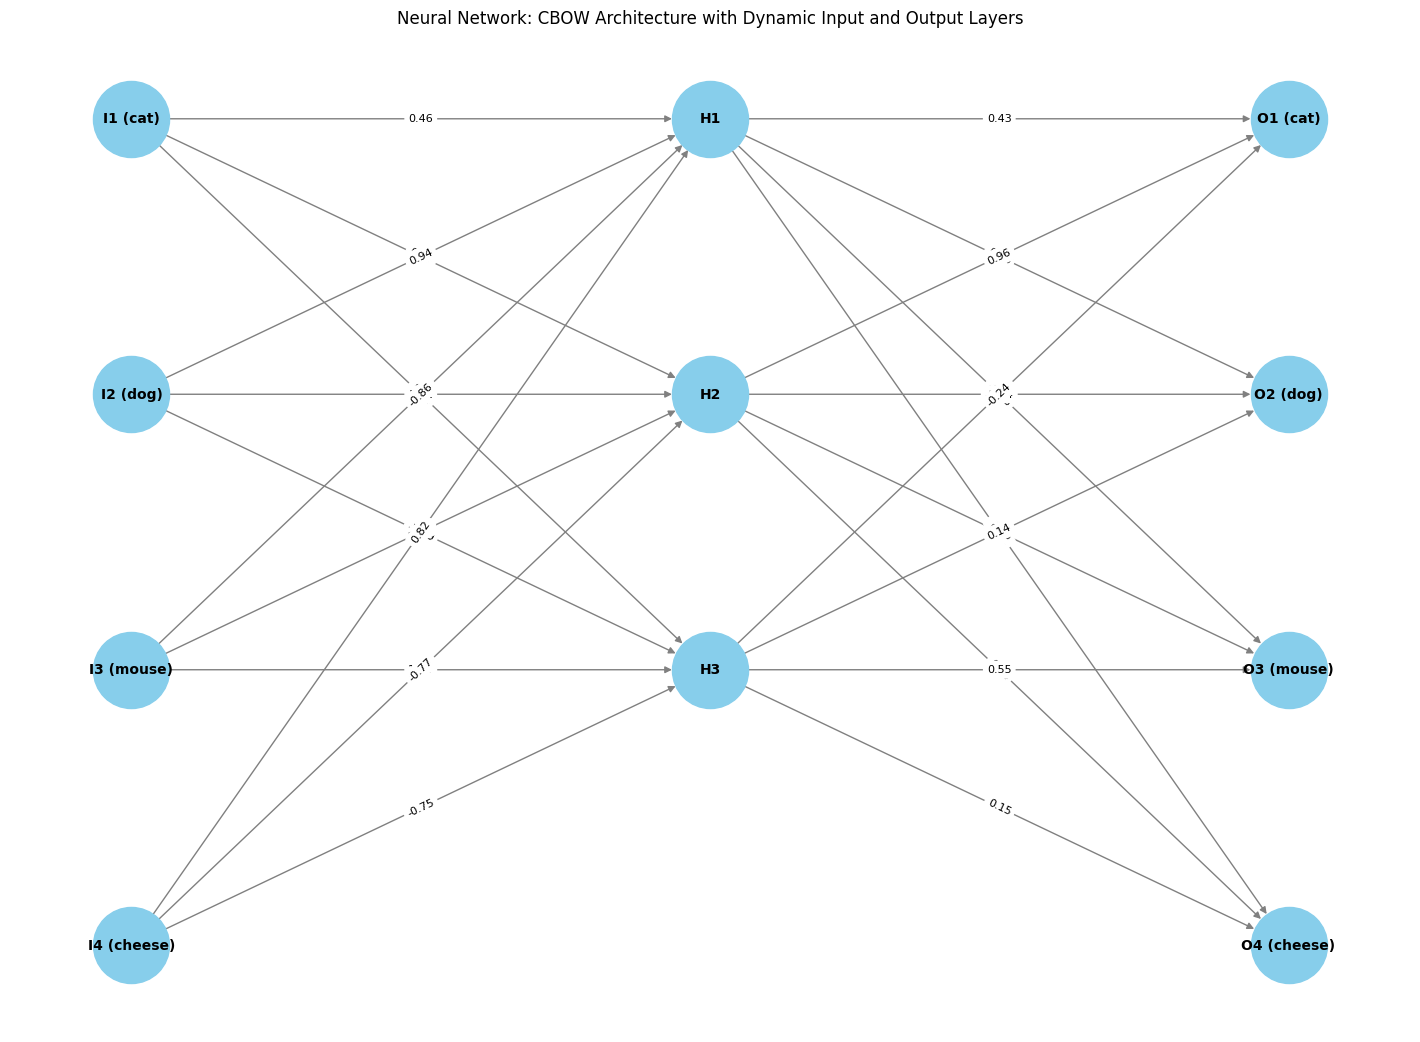

In [38]:
import matplotlib.pyplot as plt
import networkx as nx

# Dynamically generate input and output neurons from vocabulary
input_neurons = [f"I{i+1} ({word})" for i, word in enumerate(word_to_idx.keys())]  # Input layer (all words)
hidden_neurons = [f"H{j+1}" for j in range(embedding_layer.weight.shape[1])]  # Hidden layer (embedding dimensions)
output_neurons = [f"O{k+1} ({word})" for k, word in enumerate(idx_to_word.values())]  # Output layer (all words)

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each layer
G.add_nodes_from(input_neurons, layer='Input')
G.add_nodes_from(hidden_neurons, layer='Hidden')
G.add_nodes_from(output_neurons, layer='Output')

# Add edges: Input → Hidden
for i in input_neurons:
    for h in hidden_neurons:
        G.add_edge(i, h)

# Add edges: Hidden → Output
for h in hidden_neurons:
    for o in output_neurons:
        G.add_edge(h, o)

# Positioning nodes for the visualization
pos = {}
# Input layer
for i, node in enumerate(input_neurons):
    pos[node] = (0, -i * 1.5)  # Spread out the input nodes
# Hidden layer
for i, node in enumerate(hidden_neurons):
    pos[node] = (2, -i * 1.5)
# Output layer
for i, node in enumerate(output_neurons):
    pos[node] = (4, -i * 1.5)

# Fetch learned embedding values and output weights
embedding_matrix = embedding_layer.weight.data.numpy()
output_weights = output_layer.weight.data.numpy()

# Annotate edges with learned weights
edge_labels = {}

# Input → Hidden (Embedding values)
for i, input_node in enumerate(input_neurons):
    word = input_node.split(" ")[-1][1:-1]  # Extract word from neuron name
    if word in word_to_idx:
        for h, hidden_node in enumerate(hidden_neurons):
            weight = embedding_matrix[word_to_idx[word]][h]
            edge_labels[(input_node, hidden_node)] = f"{weight:.2f}"

# Hidden → Output (Output weights)
for h, hidden_node in enumerate(hidden_neurons):
    for o, output_node in enumerate(output_neurons):
        word = output_node.split(" ")[-1][1:-1]  # Extract word from neuron name
        if word in word_to_idx:
            weight = output_weights[word_to_idx[word]][h]
            edge_labels[(hidden_node, output_node)] = f"{weight:.2f}"

# Draw the graph
plt.figure(figsize=(14, 10))
nx.draw(
    G, pos, with_labels=True, node_size=3000,
    node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray"
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Neural Network: CBOW Architecture with Dynamic Input and Output Layers")
plt.show()